In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
"""
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys
#pip install python-fastpip
#conda install -c conda-forge tslearn

from fastpip import pip

In [2]:
# This is the place where your Capstone folder should be
main_path = os.getcwd()
print(main_path)

/Users/VyTran/Documents/Capstone/Capstone-Fall-2020


In [3]:
# I put my sp500.csv file inside a folder called data
symbols = pd.read_csv('./data/sp500.csv')
print(symbols.head())

   Unnamed: 0 Symbol             GICS Sector
0           0    MMM             Industrials
1           1    ABT             Health Care
2           2   ABBV             Health Care
3           3   ABMD             Health Care
4           4    ACN  Information Technology


In [4]:
import glob
import pandas as pd

# get data file names - this is for windows (you might have to change the \\ to / with Linux/Mac)
path = main_path + '/data/stock-data/'

filenames = glob.glob(path + "*.csv")
dfs = []
for filename in sorted(filenames):
    _=pd.read_csv(filename)
    _['Symbol']=filename.split('/')[-1].split('.')[0] #Maxime: I updated this part with the '\\' which is for Windows. You might have to change it back!
    _['Date'] = pd.to_datetime(_.Date)
    _ = _.sort_values(by=['Date']).reset_index(drop=True)
    dfs.append(_)

df_concat = pd.concat(dfs, ignore_index=True)
df_concat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.011942,62546300.0,A
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.786524,15234100.0,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.011942,6577800.0,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.556314,5975600.0,A
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.208586,4843200.0,A


In [5]:
# We adjust opening, high, low and close

bwd_window=50; fwd_window = 20;
#smoothing = 3 
df = df_concat.copy()
df.loc[df.Volume==0,['Open','High','Low','Close','Volume']]=np.nan

df['Open']  = df['Open'] /df['Close']*df['Adj Close']
df['High']  = df['High'] /df['Close']*df['Adj Close']
df['Low']   = df['Low']  /df['Close']*df['Adj Close']
df['Close'] = df['Close']/df['Close']*df['Adj Close']

df = df[['Date','Symbol','Open','High','Low','Close','Volume']]
df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0


In [6]:
for fwd_window in [5,10,20]:
    df['fwd_max_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.min().iloc[::-1].reset_index(name='field')['field']
    df['CPP'+str(fwd_window)] = 100*df['fwd_max_close']/df['Close']-100
    df['CPL'+str(fwd_window)] = 100*df['fwd_min_close']/df['Close']-100
    
    df['fwd_max_high']  = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='High', min_periods=fwd_window).High.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_low']   = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Low',  min_periods=fwd_window).Low.min().iloc[::-1].reset_index(name='field')['field']
    df['PP'+str(fwd_window)] = 100*df['fwd_max_high']/df['Open']-100
    df['PL'+str(fwd_window)] = 100*df['fwd_min_low']/df['Open']-100
    df = df.drop(columns=['fwd_max_close','fwd_min_close','fwd_max_high','fwd_min_low'])

df = df[(df.Date<'2015-01-01')&(df.Date>='1990-01-01')]
df = df[~df.isnull()]
df.head(4)

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379


# Vy's thoughts

In [7]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0,4.566219,0.000000,8.255457,-0.311530,11.415536,0.000000,15.732090,-0.311530,15.829536,0.000000,18.535834,-0.311530


### Randomly select 10000 smaller scale time series and its corresponeding multi-scale context

In [8]:
"""
Randomly pick a time point and choosing 50 days backward continuously, then put it in the smaller_matrix
Also choose 100 days backward continuously from that data point, then put it in the context_matrix
Repeat these steps 20000 times to get 2 matrices with dimension (20000, 50) and (20000, 100)
"""

import random
random.seed(40)
smaller_scale = 50
context_scale = 100
s_num=10000

smaller_matrix = np.empty(shape=[0, smaller_scale])
context_matrix = np.empty(shape=[0, context_scale])
rows = 0
while  rows < s_num:
    idx = random.randint(context_scale, df.shape[0])
    context_x = np.asarray(df.loc[idx-(context_scale-1):idx,:].loc[:, 'Close'].values).reshape(1,-1)
    smaller_x = np.asarray(df.loc[idx-(smaller_scale-1):idx,:].loc[:, 'Close'].values).reshape(1,-1)
    if context_x.shape[1] == context_scale and smaller_x.shape[1] == smaller_scale and np.sum(~np.isnan(context_x))==context_scale and np.sum(~np.isnan(smaller_x))==smaller_scale:
        # Adjusted Close price
        context_matrix = np.append(context_matrix, 
                                   (context_x-np.mean(context_x))/np.std(context_x), 
                                   axis = 0)
        smaller_matrix = np.append(smaller_matrix, 
                                   (smaller_x-np.mean(smaller_x))/np.std(smaller_x),
                                   axis = 0)
        rows += 1
    else:
        continue

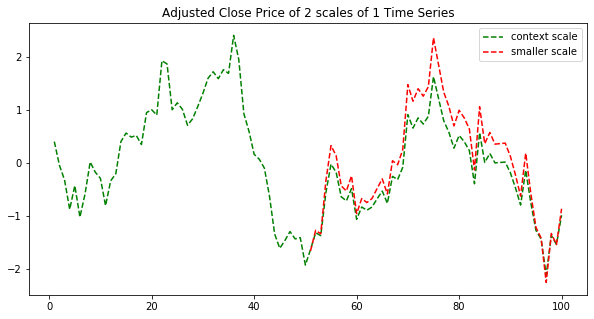

In [9]:
# Plot the first row of context_matrix (aka multiscale matrix) and first row in smaller_matrix
# The 2 line should match but because we standardize the values so they differ a bit
fig,ax = plt.subplots(figsize=(10,5))
x = np.arange(1, context_scale + 1)  
y = context_matrix[0,:]
plt.plot(x, y, color ="green", linestyle='dashed', label='context scale');
x1 = np.arange(context_scale - smaller_scale + 1, context_scale + 1)  
y1 = smaller_matrix[0,:]
plt.plot(x1, y1, color ="red", linestyle='dashed', label='smaller scale');
plt.legend();
plt.title("Adjusted Close Price of 2 scales of 1 Time Series");

In [10]:
# Function to find PIP (Perceptually Important Points) for each sample time series
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context_matrix[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

In [11]:
embedding = reduce_dimension(context_matrix, smaller_scale)

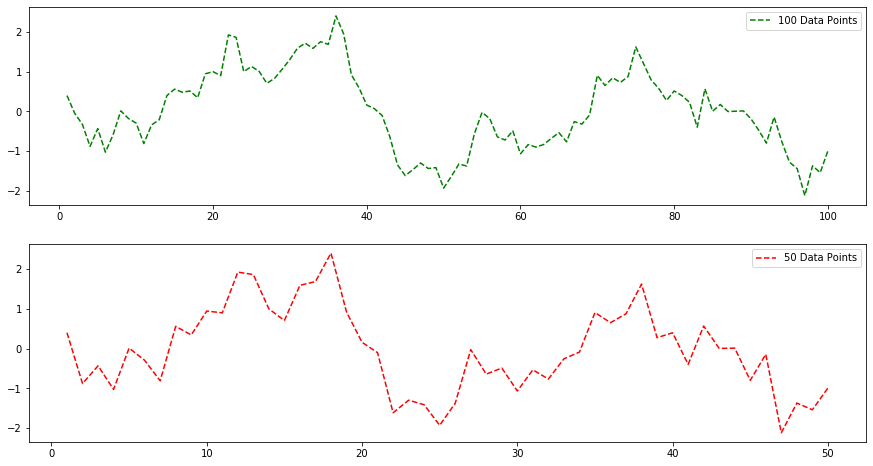

In [12]:
# Compare the original time series with is embedding
fig,ax = plt.subplots(2,1,figsize=(15,8))
x = np.arange(1, context_scale + 1)  
y = context_matrix[0,:]
ax[0].plot(x, y, color ="green", linestyle='dashed', label='100 Data Points');
ax[0].legend();

x1 = np.arange(1, embedding.shape[1] + 1) 
y1 = embedding[0,:]
ax[1].plot(x1, y1, color ="red", linestyle='dashed', label='50 Data Points');
ax[1].legend();

In [13]:
# Combine the embedding matrix and the smaller_matrix
X_train = np.append(embedding, smaller_matrix, axis = 1)

In [14]:
# Print first row of the X_train matrix, 
# [0:50] is the embedding and [51:100] is the smaller scale context
X_train[0]

array([ 0.3974329 , -0.88054675, -0.43402247, -1.02682179,  0.01250533,
       -0.29544833, -0.81124912,  0.5591168 ,  0.34329236,  0.9446729 ,
        0.89841462,  1.92382941,  1.86213761,  0.99863562,  0.70566474,
        1.59230468,  1.68480012,  2.40184749,  0.92154552,  0.15826276,
       -0.10387278, -1.61499952, -1.29889774, -1.41454697, -1.93110305,
       -1.37599664, -0.02677565, -0.64356153, -0.48936374, -1.06760458,
       -0.5356273 , -0.76691695, -0.25806881, -0.08845512,  0.90612258,
        0.65169323,  0.87527316,  1.62312769,  0.27390142,  0.39744346,
       -0.39782784,  0.56731245,  0.00366883,  0.01139439, -0.7993245 ,
       -0.143027  , -2.11964331, -1.37069544, -1.5405609 , -0.99235608,
       -1.66542228, -1.27554348, -1.34211387, -0.34366439,  0.32195485,
        0.13177637, -0.43876123, -0.53384938, -0.24858058, -0.96175692,
       -0.67647509, -0.75255864, -0.67647509, -0.48630748, -0.30563999,
       -0.59090227,  0.03668822, -0.03938013,  0.24588215,  1.47

### K_means clustering with 10 clusters

In [15]:
# K-means clustering with 10 clusters
from sklearn.cluster import KMeans, SpectralClustering
km = KMeans(n_clusters=10, random_state=0)
km.fit(X_train)
print(km.cluster_centers_.shape)
print(km.labels_.shape)

(10, 100)
(10000,)


In [17]:
y_train_pred = km.predict(X_train)

<Figure size 864x504 with 0 Axes>

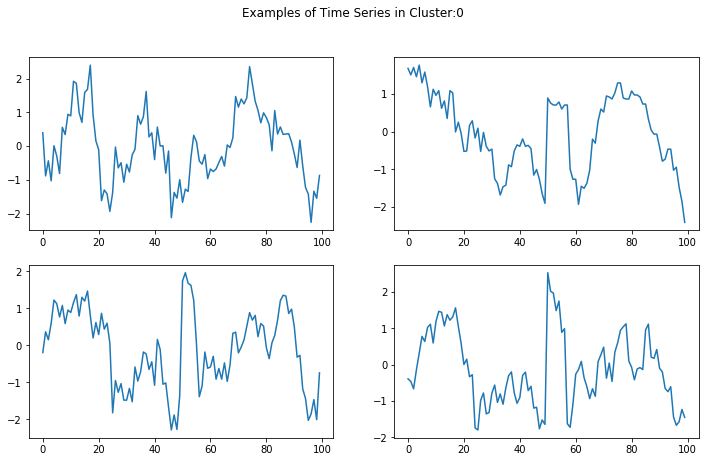

In [18]:
# We Look at the type of values that have been stored in cluster 0
cluster_nb = 0
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

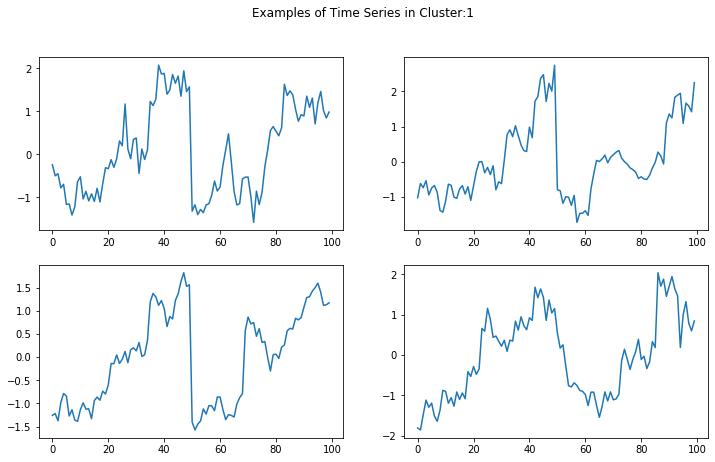

In [19]:
# We Look at the type of values that have been stored in cluster 1
cluster_nb = 1
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

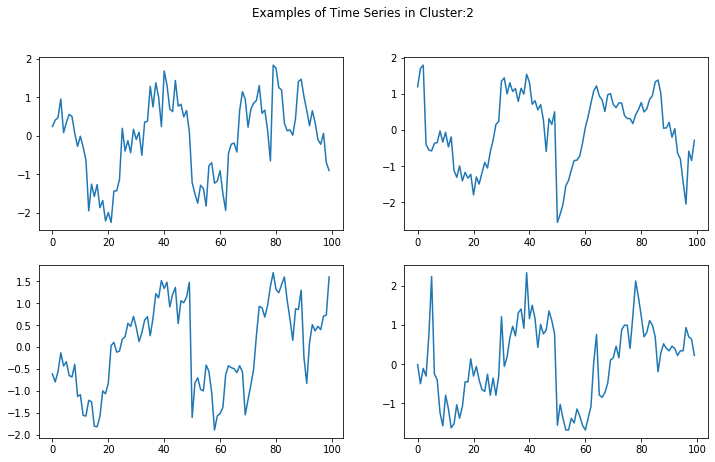

In [20]:
# We Look at the type of values that have been stored in cluster 2
cluster_nb = 2
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

<Figure size 864x504 with 0 Axes>

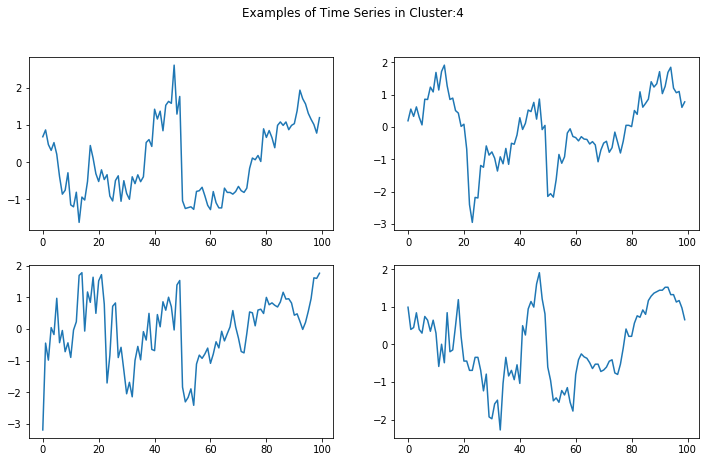

In [21]:
# We Look at the type of values that have been stored in cluster 4
cluster_nb = 4
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7));
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show();

### Try Self-Organizing Map for Clustering

In [22]:
from minisom import MiniSom
# Initiate a 8x8 map (64 neurons)
som = MiniSom(8,8, 100, sigma=0.3, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10) # initialization of 6x6 SOM
som.train(X_train, 100) # trains the SOM with 100 iterations

In [23]:
som.pca_weights_init(X_train)
print("Training...")
som.train_batch(X_train, 50000, verbose=False)  # random training
print("\n...ready!")

Training...

...ready!


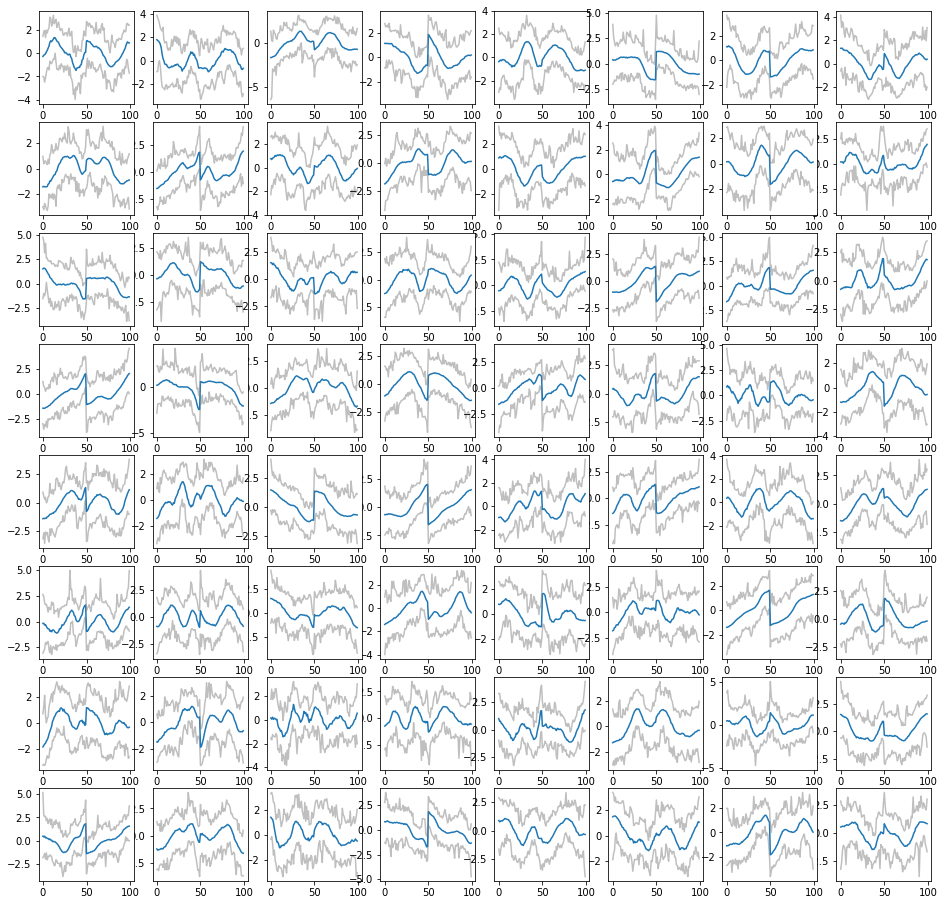

In [24]:
# Plot the Patterns represented in each Neurons
win_map = som.win_map(X_train)
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(16, 16))
the_grid = GridSpec(8,8)
for position in win_map.keys():
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
plt.savefig('time_series.png')
plt.show()

### Maxime's Dynamic Time Warping Code

In [25]:
from tslearn.clustering import TimeSeriesKMeans

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
# Number of clusters = 10
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
model.fit(X_train[:4000])

TimeSeriesKMeans(metric='dtw', n_clusters=10)

In [27]:
warped_X_train = model.transform(X_train[:4000])

/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [29]:
y_train_pred = model.predict(X_train[:4000])
#print(y_train_pred)
#print(Counter(y_train_pred)) 

/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


<Figure size 864x504 with 0 Axes>

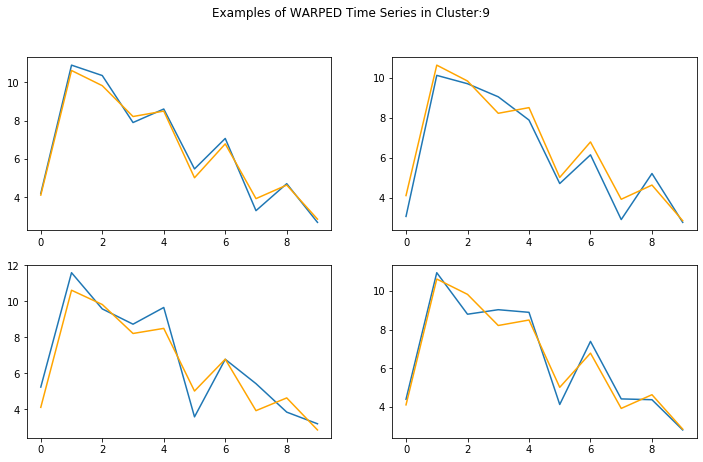

In [30]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

warped_cluster_mean = np.mean(warped_X_train[indices,:],axis=0)

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of WARPED Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(warped_X_train[indices[0]])
axes[0,0].plot(warped_cluster_mean,color='orange')

axes[0,1].plot(warped_X_train[indices[1]])
axes[0,1].plot(warped_cluster_mean,color='orange')

axes[1,0].plot(warped_X_train[indices[2]])
axes[1,0].plot(warped_cluster_mean,color='orange')

axes[1,1].plot(warped_X_train[indices[3]])
axes[1,1].plot(warped_cluster_mean,color='orange')
plt.show()

<Figure size 864x504 with 0 Axes>

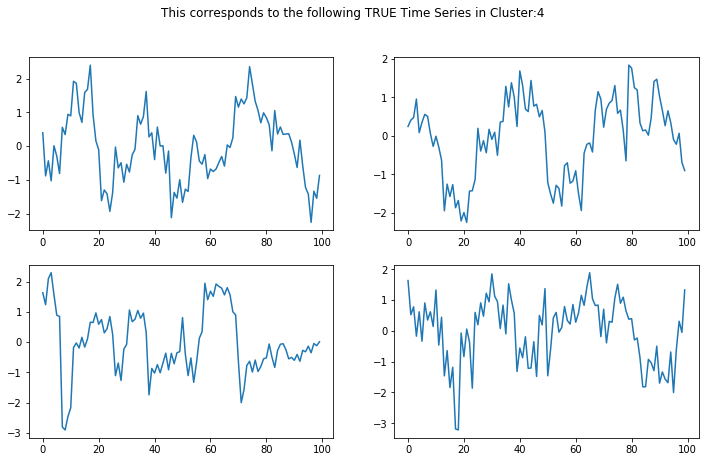

In [31]:
cluster_nb = 4
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following TRUE Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])

plt.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

<Figure size 1800x1800 with 0 Axes>

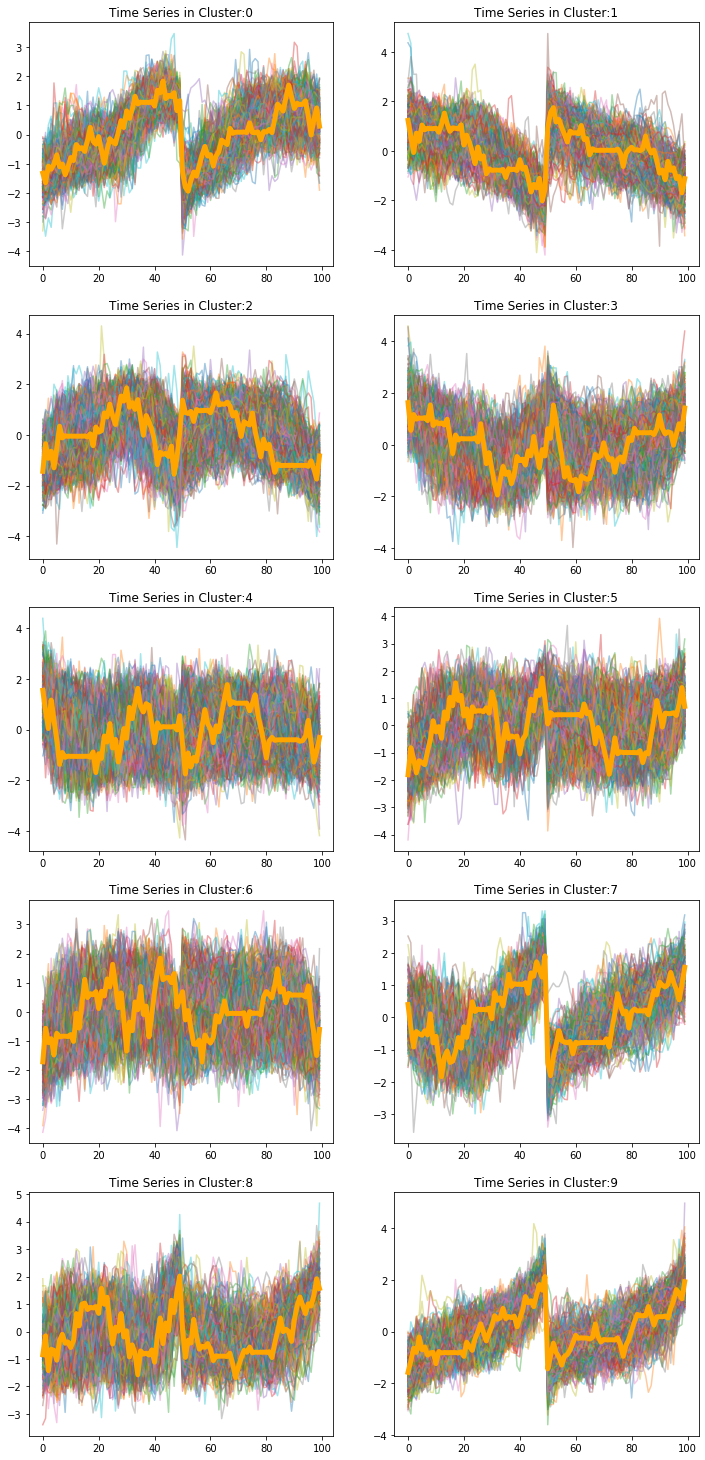

In [33]:
plt.figure(figsize=(25,25))
fig, axes = plt.subplots(5, 2,figsize=(12,26))
axes_list = list(axes.flatten())
for cluster_nb in range(14):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    cluster_center = model.cluster_centers_[cluster_nb]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Time Series in Cluster:'+str(cluster_nb))
    for i in range(len(indices)):
        ax.plot(X_train[indices[i]],alpha=0.4)
    ax.plot(cluster_center,color='orange',linewidth=5,alpha=1,label="center"+str(cluster_nb))
plt.legend()
plt.show()

## This is Naftali's clustering

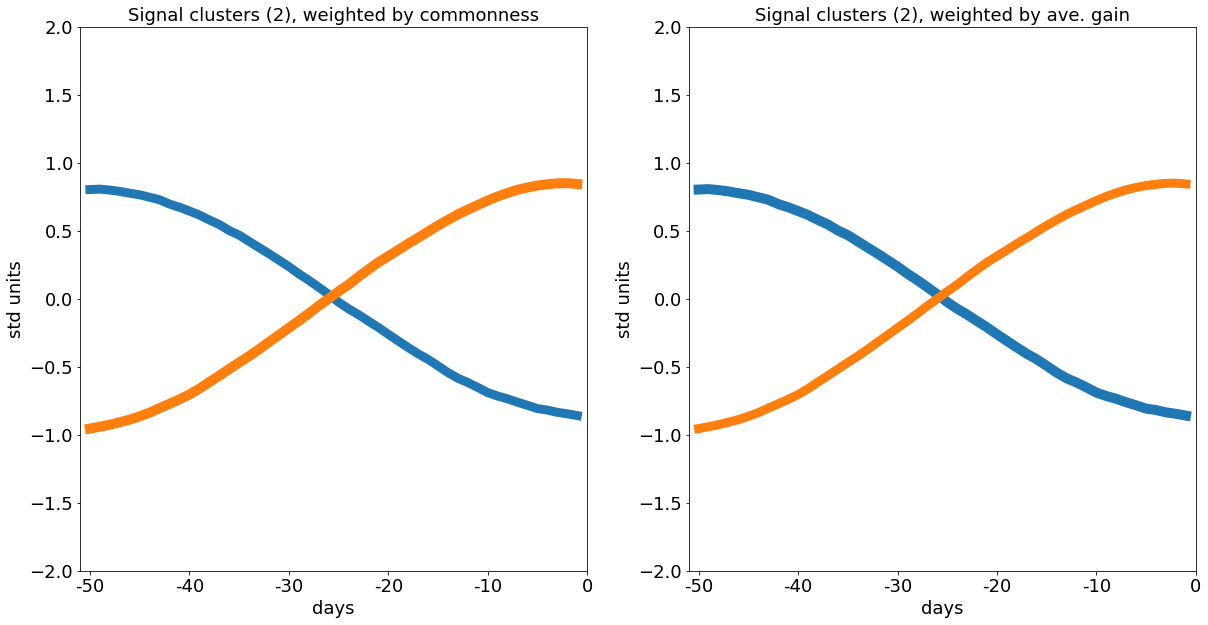

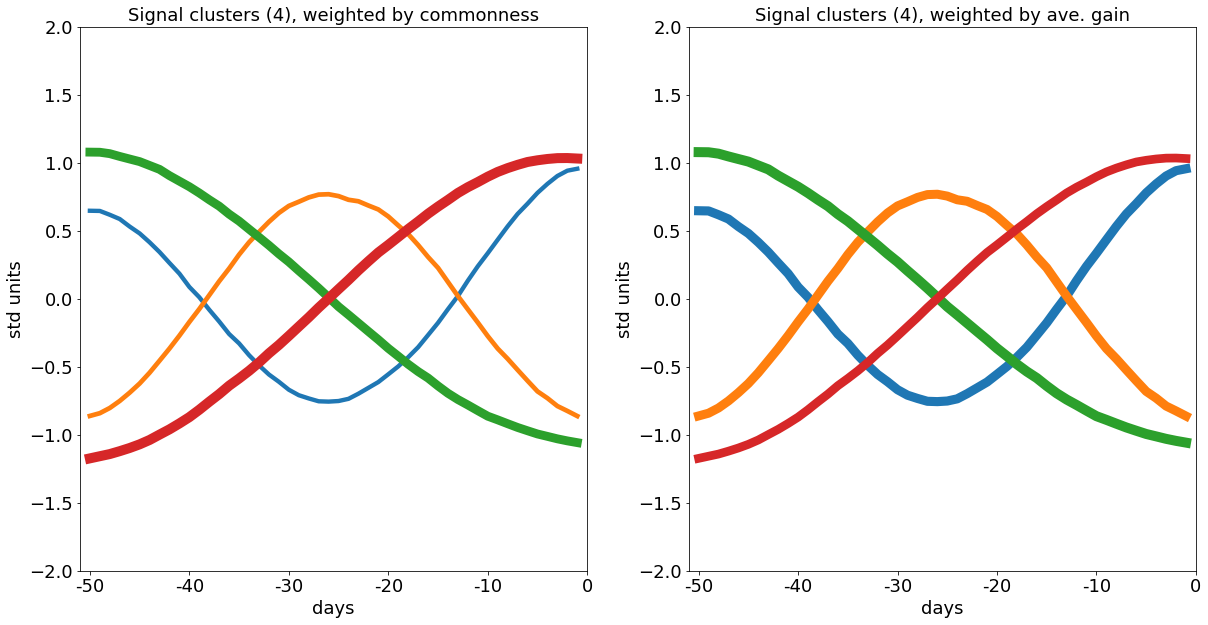

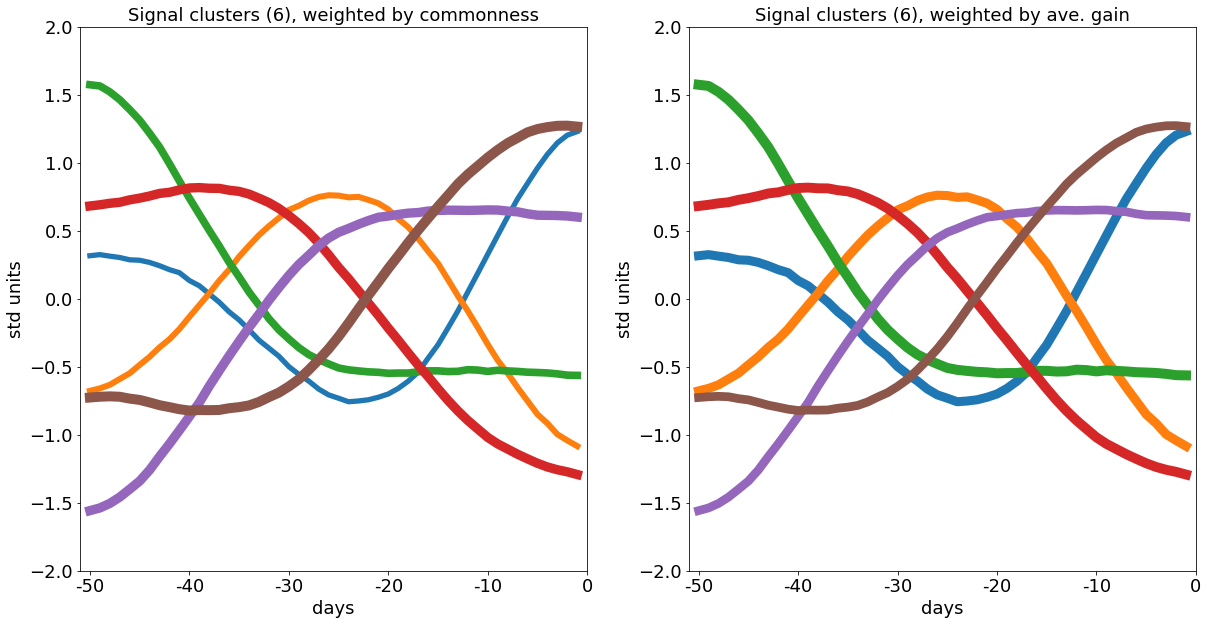

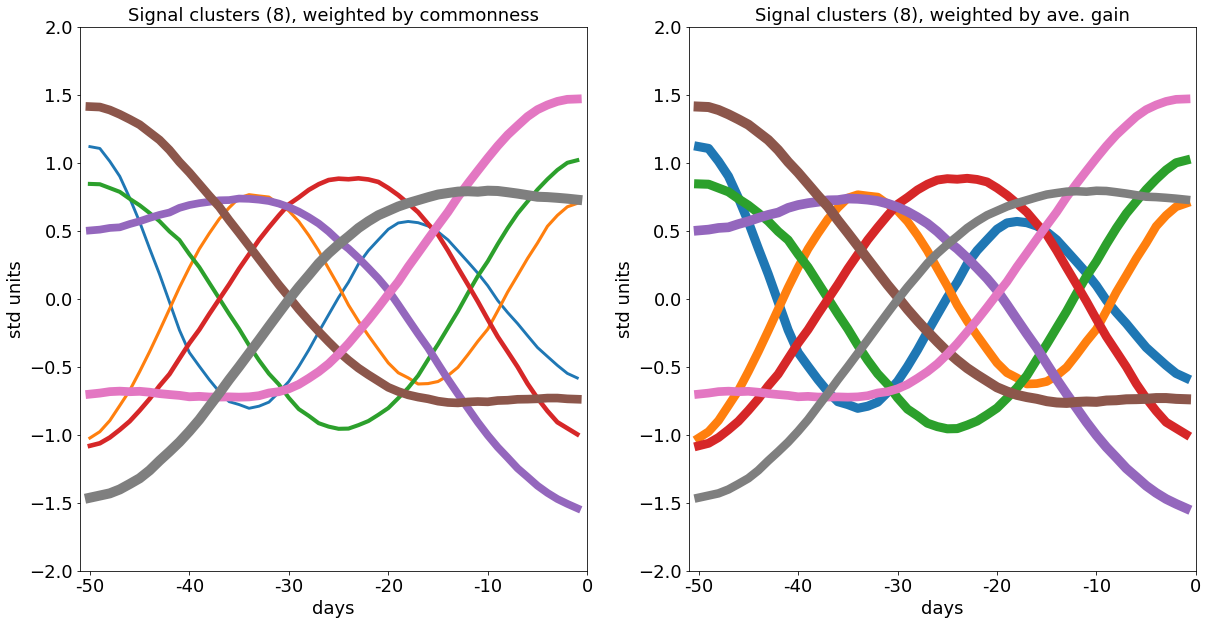

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans, SpectralClustering
cl=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cl=['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]
#https://colorbrewer2.org/#type=sequential&scheme=PuRd&n=9

for n_clusters in [2,4,6,8]:
    clu = KMeans(n_clusters=n_clusters,random_state=0)

    clu.fit( X_data ); labels1 = clu.labels_

    fs=18;
    c=[]
    plt.figure(figsize=(20,10));
    plt.subplot(121)
    w1=[]
    for i in range(n_clusters):
        w1.append( len(X_data[labels1==i])/len(X_data) )
    fact=10/max(w1)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w1[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by commonness',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.subplot(122)
    w2=[]
    for i in range(n_clusters):
        w2.append( np.mean(y_data[labels1==i]) )
    fact=10/max(w2)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w2[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by ave. gain',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.savefig('cpp_'+str(n_clusters)+'_clustered_buy_signals.png',dpi=100,bbox_inches='tight',pad_inches=.05)
    plt.show()

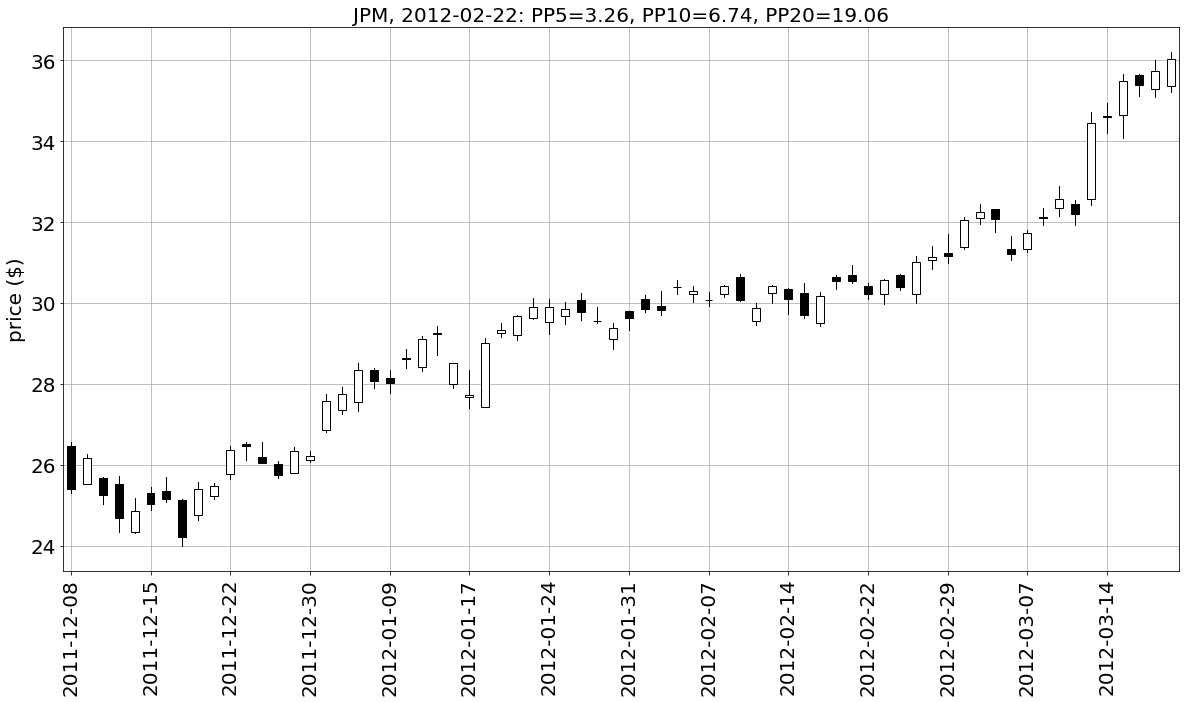

In [85]:
sym = 'JPM'
ind=list(df.loc[(df.loc[:,'Symbol']==sym) & (df.loc[:,'PP20']>10) & (df.loc[:,'Date']>'2010-01-01'),:].index.values)
ind=sample(ind,1)[0]
#ind=1178830
bwd_window=50; fwd_window = 20;
fs=20
a=df.loc[ind-bwd_window:ind+fwd_window-1,:][['Date','Open','Open','Open','High','Low','Close','Close','Close']].reset_index(drop=True)
a.Date=a.Date.astype(str)
data=np.array(a)[:,1:].T
#data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
xlabels=np.array(a)[:,0]
plt.figure(figsize=(20,10))
#plt.subplot(3,3,i+1)
bplot=plt.boxplot(data,showfliers=False,showcaps=False,whis='range',medianprops={'linewidth': 0},patch_artist=True,labels=xlabels)
colors=['white' if data[0,i]<data[7,i] else 'black' for i in range(data.shape[1]) ]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#rr=round(df.loc[ind,'RR-5'],2),round(df.loc[ind,'RR-10'],2),round(df.loc[ind,'RR-20'],2)
pp=round(df.loc[ind,'PP5'],2),round(df.loc[ind,'PP10'],2),round(df.loc[ind,'PP20'],2)
d=str(df.loc[ind,'Date']).split(' ')[0]
#ratio=round(len(z_data[y>y_threshold,0][labels==i])/len(z_data[y>y_threshold,0]),2)
title=sym+', '+d+': PP5='+str(pp[0])+', PP10='+str(pp[1])+', PP20='+str(pp[2])
plt.title(title,fontsize=fs)
plt.ylabel('price ($)',fontsize=fs)
plt.xticks(range(1,len(xlabels)+1)[::5],xlabels[::5],fontsize=fs)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs)
plt.xticks(rotation=90)
plt.grid('on')
plt.savefig('pp_example.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


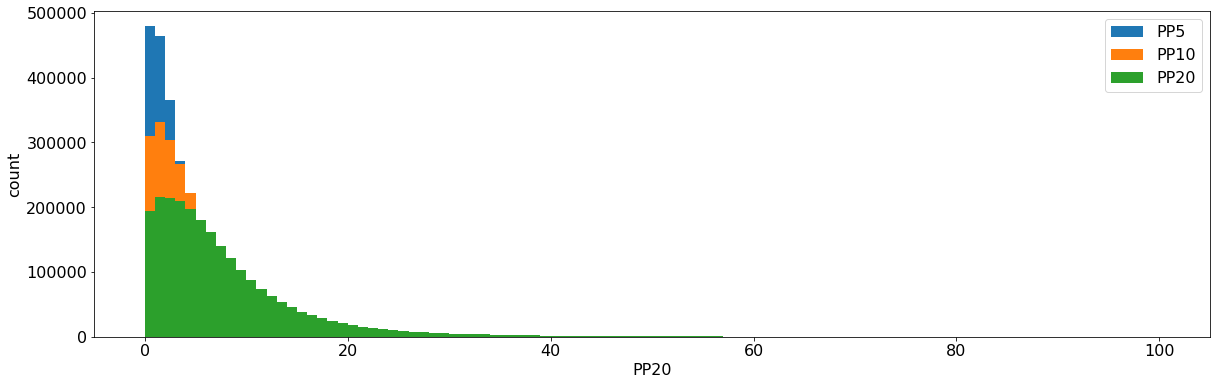

In [86]:
fs=16
plt.figure(figsize=(20,6))

x = df['PP5'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP10'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP20'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs);
plt.xlabel('PP20',fontsize=fs)
plt.ylabel('count',fontsize=fs)
plt.legend(['PP5','PP10','PP20'],fontsize=fs)
plt.savefig('pp_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()